can run locally

In [1]:
!pip install torch torchvision numpy tqdm matplotlib plotnine pandas


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


# train

In [2]:
import json
from pathlib import Path
from PIL import Image
import copy
import os
from plotnine import *
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
from utils import *


device = get_device(disable_mps=False)
set_env()


#
# data
#


data_path = get_current_dir().parent / "data"
dataset_path = get_current_dir().parent / "datasets"
weights_path = get_current_dir().parent / "weights"

os.makedirs(data_path, exist_ok=True)
os.makedirs(dataset_path, exist_ok=True)
os.makedirs(weights_path, exist_ok=True)


dataset = "imagenette"

if dataset == "cifar10":
    num_classes = 10
    trainset = torchvision.datasets.CIFAR10(root=dataset_path, train=True, download=True, transform=torchvision.transforms.ToTensor())
    testset = torchvision.datasets.CIFAR10(root=dataset_path, train=False, download=True, transform=torchvision.transforms.ToTensor())

    original_images_train_np = np.array(trainset.data)
    original_labels_train_np = np.array(trainset.targets)

    original_images_test_np = np.array(testset.data)
    original_labels_test_np = np.array(testset.targets)

elif dataset == "cifar100":
    num_classes = 100
    trainset = torchvision.datasets.CIFAR100(root=dataset_path, train=True, download=True, transform=torchvision.transforms.ToTensor())
    testset = torchvision.datasets.CIFAR100(root=dataset_path, train=False, download=True, transform=torchvision.transforms.ToTensor())

    original_images_train_np = np.array(trainset.data)
    original_labels_train_np = np.array(trainset.targets)

    original_images_test_np = np.array(testset.data)
    original_labels_test_np = np.array(testset.targets)

elif dataset == "imagenette":
    num_classes = 10
    imgpath = dataset_path / "imagenette2"
    transform = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize((224, 224)),
            torchvision.transforms.ToTensor(),
        ]
    )
    trainset = torchvision.datasets.Imagenette(root=dataset_path, split="train", download=(not (imgpath / "train").exists()), transform=transform)
    testset = torchvision.datasets.Imagenette(root=dataset_path, split="val", download=(not (imgpath / "val").exists()), transform=transform)

    # preallocate
    num_train = len(trainset)
    num_test = len(testset)
    original_images_train_np = np.empty((num_train, 224, 224, 3), dtype=np.uint8)
    original_labels_train_np = np.empty(num_train, dtype=np.int64)
    original_images_test_np = np.empty((num_test, 224, 224, 3), dtype=np.uint8)
    original_labels_test_np = np.empty(num_test, dtype=np.int64)

    for idx, (image, label) in tqdm(enumerate(trainset), total=num_train, desc="preprocessing trainset", ncols=100):
        original_images_train_np[idx] = (np.transpose(image.numpy(), (1, 2, 0)) * 255).astype(np.uint8)
        original_labels_train_np[idx] = label

    for idx, (image, label) in tqdm(enumerate(testset), total=num_test, desc="preprocessing testset", ncols=100):
        original_images_test_np[idx] = (np.transpose(image.numpy(), (1, 2, 0)) * 255).astype(np.uint8)
        original_labels_test_np[idx] = label

else:
    assert False

images_train_np = original_images_train_np / 255.0  # map to [0, 1]
images_test_np = original_images_test_np / 255.0
labels_train_np = original_labels_train_np
labels_test_np = original_labels_test_np

preprocessing testset: 100%|███████████████████████████████████| 3925/3925 [00:13<00:00, 296.30it/s]


adding overlay: 100%|█████████████████████████████████████████| 3925/3925 [00:02<00:00, 1341.98it/s]


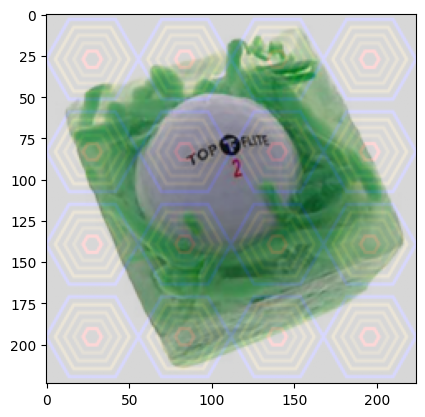

In [3]:
# 
# perturbed testset
# 


def add_overlay(background: Image.Image, overlay: Image.Image, opacity: int) -> Image.Image:
    # opacity range: 0 (transparent) to 255 (opaque)
    overlay = overlay.resize(background.size)
    result = Image.new("RGBA", background.size)
    result.paste(background, (0, 0))
    mask = Image.new("L", overlay.size, opacity)
    result.paste(overlay, (0, 0), mask)
    return result

mask_opacity = 40 # 0 (transparent) to 255 (opaque)
mask = Image.open((get_current_dir().parent / "data" / "masks" / "mask.png"))
for i in tqdm(range(len(images_test_np)), desc="adding overlay", ncols=100):
    to_pil = lambda x: Image.fromarray((x * 255).astype(np.uint8))
    to_np = lambda x: np.array(x) / 255.0
    images_test_np[i] = to_np(add_overlay(to_pil(images_test_np[i]), mask, mask_opacity).convert("RGB"))

# get random img
idx = np.random.randint(len(images_test_np))
plt.imshow(images_test_np[idx])

In [ ]:
#
# tuning model
#

free_mem()

from torchvision.models import resnet152, ResNet152_Weights

model = resnet152(weights=ResNet152_Weights.IMAGENET1K_V2)
model.fc = nn.Linear(2048, num_classes)

model = model.to(device)
model.train()

num_epochs = 6
learning_rate = 0.001
batch_size = 128
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

if num_epochs > 0:
    train_dataset = TensorDataset(torch.FloatTensor(images_train_np).permute(0, 3, 1, 2), torch.LongTensor(labels_train_np))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(torch.FloatTensor(images_test_np).permute(0, 3, 1, 2), torch.LongTensor(labels_test_np))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        # train
        for inputs, labels in tqdm(train_loader, desc=f'epoch {epoch+1}/{num_epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = 100. * correct / total
        
        # eval
        model.eval()
        test_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()
        
        test_loss = test_loss / len(test_loader)
        test_acc = 100. * correct / total
        
        print(f'epoch [{epoch+1}/{num_epochs}]: train loss: {train_loss:.4f} | train acc: {train_acc:.2f}% | test loss: {test_loss:.4f} | test acc: {test_acc:.2f}%')


#
# eval
#


model.eval()
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="evaluating", ncols=100):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

print("results:")
print(json.dumps({
    "model": "resnet152",
    "dataset": dataset,
    "mask_opacity": mask_opacity,
    "num_epochs": num_epochs,
    "accuracy": correct / total,
}, indent=4))

epoch 1/6:   0%|          | 0/74 [00:33<?, ?it/s]


RuntimeError: MPS backend out of memory (MPS allocated: 17.74 GB, other allocations: 394.77 MB, max allowed: 18.13 GB). Tried to allocate 98.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).